In [11]:
import gzip
import pickle
import networkx as nx
import pandas as pd
import numpy as np
import random
import os

In [12]:
from torch.optim import SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau

## Data Loading

### Writing PyG Dataset

In [13]:
import torch

In [14]:
from torch_geometric.data import InMemoryDataset
from torch.utils.data import DataLoader

In [15]:
from torch_geometric.utils import from_networkx, to_networkx

In [16]:
def clustering_coefficient(G, node):
    ns = [n for n in G.neighbors(node)]
    if len(ns) <= 1:
        return 0
    
    numerator = 0
    denominator = len(ns) * (len(ns) - 1) / 2
    for i in range(0, len(ns)):
        for j in range(i+1, len(ns)):
            n1, n2 = ns[i], ns[j]
            numerator += G.has_edge(n1, n2)
    
    return numerator / denominator
                

In [17]:
def generate_feature_vector(G):
    x = torch.randn(G.number_of_nodes(), 4)
    ind = 0
    for node in G.nodes():
        x[ind][0] = 1 # uniform
        x[ind][1] = G.degree[node] # node degree as a scalar 
        x[ind][2] = clustering_coefficient(G, node) # triangle counting?
        x[ind][2] = ind # node ID features
        ind += 1
    return x

In [18]:
class LamanDataset(InMemoryDataset):
    def __init__(self, root, data_dir, transform=None, pre_transform=None, pre_filter=None):
        self.data_dir = data_dir
        super().__init__(root, transform, pre_transform, pre_filter)
        self.data, self.slices = torch.load(self.processed_paths[0])
        
    @property
    def processed_file_names(self):
        return ['data.pt']
        
    def process(self):
        total_laman_data = None
        with gzip.open(self.data_dir, 'r') as f:
            total_laman_data = pickle.load(f)
            
        data_list = []
        for ind, graph in enumerate(total_laman_data[0]):
            x = generate_feature_vector(graph)
            graph_as_data = from_networkx(graph)
            graph_as_data.x = x
            graph_as_data.label = 0
            data_list.append(graph_as_data)
            
        for ind, graph in enumerate(total_laman_data[1]):
            x = generate_feature_vector(graph)
            graph_as_data = from_networkx(graph)
            graph_as_data.x = x
            graph_as_data.label = 1
            data_list.append(graph_as_data)
            
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

In [21]:
DATA_PATH = "data/merged_erdos_laman.pkl.gz"

In [22]:
laman_data = LamanDataset("", DATA_PATH)

Processing...
Done!


In [23]:
laman_data[0]

Data(edge_index=[2, 128], x=[30, 4], label=[1], num_nodes=30)

## Split into Train / Test

In [28]:
from torch.utils.data import random_split

proportions = [.7, .3]
lengths = [int(p * len(laman_data)) for p in proportions]
lengths[-1] = len(laman_data) - sum(lengths[:-1])

generator1 = torch.Generator().manual_seed(42)
train_data, test_data = random_split(laman_data, lengths, generator=generator1)

In [29]:
from torch_geometric.loader import DataLoader
train_loader = DataLoader(train_data, batch_size = 256, shuffle=True)
test_loader = DataLoader(test_data, batch_size = 256, shuffle=True)

In [30]:
print("Number of train batches: ", len(train_loader))
print("Number of test batches: ", len(test_loader))

Number of train batches:  91
Number of test batches:  39


In [31]:
for data in train_loader:
    print(data)
    break

DataBatch(edge_index=[2, 31598], x=[7343, 4], label=[256], num_nodes=7343, batch=[7343], ptr=[257])


## Model Architecture & Training

In [32]:
from gin.gin import GIN

In [33]:
model = GIN(num_features=4, dim_h = 2)
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GIN(
  (conv1): GINConv(nn=Sequential(
    (0): Linear(in_features=4, out_features=2, bias=True)
    (1): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=2, out_features=2, bias=True)
    (4): ReLU()
  ))
  (conv2): GINConv(nn=Sequential(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=2, out_features=2, bias=True)
    (4): ReLU()
  ))
  (conv3): GINConv(nn=Sequential(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=2, out_features=2, bias=True)
    (4): ReLU()
  ))
  (conv4): GINConv(nn=Sequential(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [34]:
from torch_geometric.data import DataLoader
from torch.nn import BCELoss
import warnings
warnings.filterwarnings("ignore")

loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(),
                                      lr=0.001)

# scheduler = ReduceLROnPlateau(optimizer, 'min', min_lr=1e-6, verbose=True, patience=10)

In [35]:
def train(model, data, features_to_use):
    ind = 0
    for batch in data:
        optimizer.zero_grad()
        pred, embedding = model(batch.x[:, features_to_use], batch.edge_index, batch.batch)
        pred = torch.squeeze(pred)
        loss = loss_fn(pred.float(), batch.label.float())
        loss.backward()
        optimizer.step()
        ind += 1

    return loss, model

In [36]:
def check_accuracy(model, loader, features_to_use):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for batch in loader:
            pred, embedding = model(batch.x[:, features_to_use], batch.edge_index, batch.batch)
            pred = torch.squeeze(pred)
            y = batch.label
            predictions = (pred > 0.5).long() 
            num_correct += (predictions == y).sum() 
            num_samples += predictions.size(0)
            
    return float(num_correct)/float(num_samples)*100

In [37]:
print("Starting training...")
losses = []

bestModel, highestAcc = None, 0

for epoch in range(1000):
    loss, model = train(model, train_loader, [0, 1, 2, 3])
    losses.append(loss)
    print(f"Epoch {epoch} | Train loss {loss}")
    train_acc, test_acc = check_accuracy(model, train_loader, [0, 1, 2, 3]), check_accuracy(model, test_loader, [0, 1, 2, 3])
    print(f"Train Accuracy {train_acc} | Test Accuracy {test_acc}")
    
    if test_acc > highestAcc:
        highestAcc = test_acc
        bestModel = model

Starting training...
Epoch 0 | Train loss 0.33679813146591187
Train Accuracy 87.2706867527086 | Test Accuracy 87.30990029207373
Epoch 1 | Train loss 0.2505302131175995
Train Accuracy 89.26490266327103 | Test Accuracy 89.47527444858495
Epoch 2 | Train loss 0.21181923151016235
Train Accuracy 90.28359304182673 | Test Accuracy 90.66371235773995
Epoch 3 | Train loss 0.16970482468605042
Train Accuracy 92.64902663271032 | Test Accuracy 92.78880048343237
Epoch 4 | Train loss 0.12686745822429657
Train Accuracy 95.40294384253464 | Test Accuracy 95.47789304058819
Epoch 5 | Train loss 0.11544802784919739
Train Accuracy 96.46048258298443 | Test Accuracy 96.4548292879444
Epoch 6 | Train loss 0.07025624066591263
Train Accuracy 96.68062330038417 | Test Accuracy 96.61597341121966
Epoch 7 | Train loss 0.060627855360507965
Train Accuracy 96.7928519014115 | Test Accuracy 96.62604491892436
Epoch 8 | Train loss 0.1222018375992775
Train Accuracy 96.91371347174861 | Test Accuracy 96.78718904219961
Epoch 9 | T

KeyboardInterrupt: 

In [38]:
# sanity check

In [39]:
# test on best model

In [40]:
# square
import networkx as nx
square = nx.Graph()
square.add_edge(0, 1)
square.add_edge(1, 3)
square.add_edge(0, 2)
square.add_edge(2, 3)

In [41]:
# square with cross bar (rigid)
import networkx as nx
square_bar = nx.Graph()
square_bar.add_edge(0, 1)
square_bar.add_edge(1, 3)
square_bar.add_edge(0, 2)
square_bar.add_edge(2, 3)
square_bar.add_edge(0, 3)
square_bar.add_edge(1, 2)

In [42]:
# triangle
import networkx as nx
triangle = nx.Graph()
triangle.add_edge(0, 1)
triangle.add_edge(0, 2)
triangle.add_edge(1, 2)

In [43]:
# pentagon
import networkx as nx
pentagon = nx.Graph()
pentagon.add_edge(0, 1)
pentagon.add_edge(1, 3)
pentagon.add_edge(3, 4)
pentagon.add_edge(4, 2)
pentagon.add_edge(2, 0)

In [44]:
# no triangle and rigid
rigid = nx.Graph()
rigid.add_edge(0, 1)
rigid.add_edge(0, 2)
rigid.add_edge(0, 4)
rigid.add_edge(1, 2)
rigid.add_edge(1, 5)
rigid.add_edge(2, 3)
rigid.add_edge(3, 4)
rigid.add_edge(3, 5)
rigid.add_edge(4, 5)

In [45]:
toy_problems = [square, square_bar, triangle, pentagon, rigid]
labels = [1, 0, 0, 1, 0]

for index, toy_problem in enumerate(toy_problems):
    graph_as_data = from_networkx(toy_problem)
    graph_as_data.x = generate_feature_vector(toy_problem)
    graph_as_data.label = labels[index]
    validation_set = DataLoader([graph_as_data], batch_size = 1, shuffle=True)
    for batch in validation_set:
        pred = model(batch.x[:, [0, 1, 2, 3]], batch.edge_index, batch.batch)
        print(pred[0])
    

tensor([[0.9998]], grad_fn=<SigmoidBackward0>)
tensor([[0.1290]], grad_fn=<SigmoidBackward0>)
tensor([[0.9930]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000]], grad_fn=<SigmoidBackward0>)
tensor([[0.7583]], grad_fn=<SigmoidBackward0>)


In [46]:
from pebble import lattice

In [47]:
rigid_data, not_rigid_data = [], []
stats = {}
stats_considered = {}
prev_graphs = []

stats_wrong = {}

num_nodes = 30
for p in np.arange(0.01, 0.3, 0.01):
    stats[p] = 0
    stats_wrong[p] = 0
    for num_graphs in range(1000):
        G = nx.erdos_renyi_graph(num_nodes, p)        
        l = lattice()
        num_edges = 0

        for (u, v) in G.edges():
            if l.add_bond(u, v):
                num_edges += 1

        label = 1
        rigid = False
        if num_edges >= (num_nodes * 2) - 3: # rigid 
            rigid = True
            stats[p] += 1
            label = 0

        graph_as_data = from_networkx(G)
        graph_as_data.x = generate_feature_vector(G)
        validation_set = DataLoader([graph_as_data], batch_size = 1, shuffle=True)
        for batch in validation_set:
            pred = model(batch.x[:, [0, 1, 2, 3]], batch.edge_index, batch.batch)
            pred_label = 1
            if (pred[0][0][0] < 0.5):
                pred_label = 0
                
            if pred_label != label:
                print(pred[0][0][0] , " ", label)
                stats_wrong[p] += 1
                print("wrong: , with number of edges: " , G.number_of_edges(), " ", num_edges)
                
    print(stats[p])

0
0
0
0
0
0
0
0
0
tensor(0.7957, grad_fn=<SelectBackward0>)   0
wrong: , with number of edges:  59   57
1
tensor(0.7141, grad_fn=<SelectBackward0>)   0
wrong: , with number of edges:  63   57
tensor(0.4282, grad_fn=<SelectBackward0>)   1
wrong: , with number of edges:  65   56
5
tensor(0.8830, grad_fn=<SelectBackward0>)   0
wrong: , with number of edges:  58   57
tensor(0.2283, grad_fn=<SelectBackward0>)   1
wrong: , with number of edges:  62   56
tensor(0.3798, grad_fn=<SelectBackward0>)   1
wrong: , with number of edges:  66   56
11
tensor(0.0998, grad_fn=<SelectBackward0>)   1
wrong: , with number of edges:  63   56
tensor(0.0717, grad_fn=<SelectBackward0>)   1
wrong: , with number of edges:  68   56
tensor(0.3671, grad_fn=<SelectBackward0>)   1
wrong: , with number of edges:  62   56
tensor(0.0795, grad_fn=<SelectBackward0>)   1
wrong: , with number of edges:  64   56
tensor(0.7457, grad_fn=<SelectBackward0>)   0
wrong: , with number of edges:  64   57
tensor(0.0244, grad_fn=<Selec

tensor(0.0049, grad_fn=<SelectBackward0>)   1
wrong: , with number of edges:  69   56
tensor(0.4197, grad_fn=<SelectBackward0>)   1
wrong: , with number of edges:  69   56
tensor(0.0097, grad_fn=<SelectBackward0>)   1
wrong: , with number of edges:  75   56
tensor(0.0232, grad_fn=<SelectBackward0>)   1
wrong: , with number of edges:  68   56
tensor(0.2131, grad_fn=<SelectBackward0>)   1
wrong: , with number of edges:  70   56
tensor(0.0087, grad_fn=<SelectBackward0>)   1
wrong: , with number of edges:  66   56
389
tensor(0.3635, grad_fn=<SelectBackward0>)   1
wrong: , with number of edges:  81   56
tensor(0.1234, grad_fn=<SelectBackward0>)   1
wrong: , with number of edges:  81   56
tensor(0.0100, grad_fn=<SelectBackward0>)   1
wrong: , with number of edges:  79   56
tensor(0.2830, grad_fn=<SelectBackward0>)   1
wrong: , with number of edges:  72   56
tensor(0.1147, grad_fn=<SelectBackward0>)   1
wrong: , with number of edges:  81   56
tensor(0.1265, grad_fn=<SelectBackward0>)   1
wron

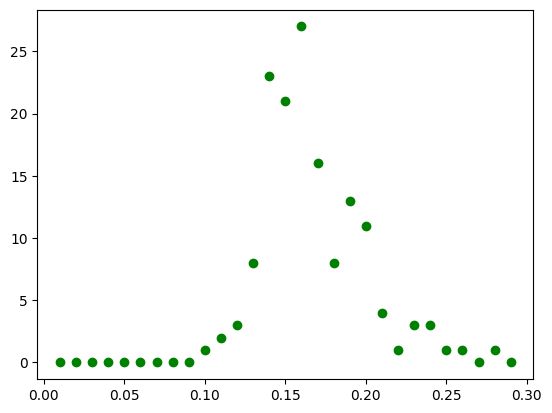

In [48]:
import matplotlib.pyplot as plt

plt.scatter(list(stats_wrong.keys()), stats_wrong.values(), color='g')
plt.show()

In [ ]:
validation_set = DataLoader([graph_as_data], batch_size = 1, shuffle=True)

In [ ]:
for batch in validation_set:
    pred = bestModel(batch.x, batch.edge_index, batch.batch)
    print(pred[0])
    print(pred[1])

In [ ]:
class LamanTestDataset(InMemoryDataset):
    def __init__(self, root, data_dir, transform=None, pre_transform=None, pre_filter=None):
        self.data_dir = data_dir
        super().__init__(root, transform, pre_transform, pre_filter)
        self.data, self.slices = torch.load(self.processed_paths[0])
        
    @property
    def processed_file_names(self):
        return ['data_test.pt']
        
    def process(self):
        # processing code here
        total_laman_data = None
        with gzip.open(self.data_dir, 'r') as f:
            total_laman_data = pickle.load(f)
            
        data_list = []
        ind = 0
        # convert from graph to Data object
        for graph in total_laman_data[0]:
#             print(ind)
            ind += 1
            num_nodes = nx.number_of_nodes(graph)
#             x = torch.randn(num_nodes, 1)
            x = generate_feature_vector(graph)
            graph_as_data = from_networkx(graph)
            graph_as_data.x = x
            graph_as_data.label = 0
            data_list.append(graph_as_data)
            
        ind = 0
        for graph in total_laman_data[1]:
#             print(ind)
            ind += 1
            num_nodes = nx.number_of_nodes(graph)
#             x = torch.randn(num_nodes, 64)
            x = generate_feature_vector(graph)
            graph_as_data = from_networkx(graph)
            graph_as_data.x = x
            graph_as_data.label = 1
            data_list.append(graph_as_data)
            
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

In [ ]:
# add functionality to support a test dataset
TEST_DATA_PATH = "../data-2d/data/test-dataset-30loc-5std.pkl.gz"
laman_test_set = LamanTestDataset("", TEST_DATA_PATH)

In [ ]:
from torch_geometric.loader import DataLoader
laman_test_loader = DataLoader(laman_test_set, batch_size = 2, shuffle=True)

In [ ]:
random_test_acc = check_accuracy(bestModel, laman_test_loader, [1])
print(f"Accuracy {random_test_acc}")

In [ ]:
# generate statistics on the data

In [ ]:
# test the clustering coefficient

In [ ]:
clustering_coefficient(square, 0)

In [ ]:
clustering_coefficient(triangle, 0)

In [ ]:
clustering_coefficient(square_bar, 0)

In [ ]:
# generate graph correlating clustering coefficient to rigidity

In [ ]:
for item in train_data:
    item = to_networkx(item)
    print(type(item))
    
    break

In [ ]:
torch_geometric.utils.convert.to_networkx()

# Scratch Work: Sahil

In [ ]:
total_laman_data = None
with gzip.open(DATA_PATH, 'r') as f:
    total_laman_data = pickle.load(f)

In [ ]:
sample_graph = total_laman_data[0][0]

In [ ]:
print(type(sample_graph))

In [ ]:
to_data = from_networkx(sample_graph)
from_data = to_networkx(to_data, to_undirected = True)

In [ ]:
print(type(from_data))

In [ ]:
def compute_min_clustering_coefficient(G):
    min_coefficient = 1
    for node in G.nodes():
        min_coefficient = min(min_coefficient, clustering_coefficient(G, node))
        
    return min_coefficient

In [ ]:
for index, sample_graph in enumerate(train_data):
    label = sample_graph.label
    networkx_sample_graph = to_networkx(sample_graph, to_undirected = True)
    print(label, " ", index, " ", compute_min_clustering_coefficient(networkx_sample_graph))
    
    if index == 10:
        break

In [ ]:
print(compute_min_clustering_coefficient(from_data))

In [ ]:
compute_min_clustering_coefficient(triangle)

In [ ]:
# what if instead of training a gnn – you just trained on 

In [ ]:
# train a binary classifier on just the degrees of the nodes



In [ ]:
# train a binary classifier on just the triangle feature

In [ ]:
# train a binary classifier on the triangle features and the degree

In [ ]:
# train a network with just degree of the node 

In [ ]:
model_just_degree = GIN(num_features=1)
print(model_just_degree)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

In [ ]:
print("Starting training...")
losses = []

bestModel, highestAcc = None, 0

for epoch in range(1000):
    loss, h = train(train_loader, [0])
    losses.append(loss)
    print(f"Epoch {epoch} | Train loss {loss}")
    train_acc, test_acc = check_accuracy(model_just_degree, train_loader), check_accuracy(model_just_degree, test_loader)
    print(f"Train Accuracy {train_acc} | Test Accuracy {test_acc}")
#     scheduler.step(test_acc)
    
    if test_acc > highestAcc:
        highestAcc = test_acc
        bestModel = model

In [ ]:
generate_feature_vector(sample_graph)

In [ ]:
sample_graph.x[:, [0, 1]]

In [ ]:
# try random graph topologies and consider their realizations

In [ ]:
import networkx as nx
import numpy as np

In [ ]:
from pebble import lattice
from tqdm import tqdm

In [ ]:
rigid_data, not_rigid_data = [], []
stats = {}
prev_graphs = []


num_nodes = 30
for p in np.arange(0.05, 0.3, 0.01):
    stats[p] = 0
    for num_graphs in tqdm(range(1000)):
        G = nx.erdos_renyi_graph(num_nodes, p)
        
        add = True
        for prev_graph in prev_graphs:
            if add:
                if nx.is_isomorphic(G, prev_graph):
                    add = False
                    print("isomorphic graph")
        
        if add:
            # determine rigdity in two-dimensions
            l = lattice()
            num_edges = 0

            for (u, v) in G.edges():
                if l.add_bond(u, v):
                    num_edges += 1

            rigid = False
            if num_edges >= (num_nodes * 2) - 3: # rigid 
                rigid_data.append(G)
                stats[p] += 1
            else:
                not_rigid_data.append(G)
            
            prev_graphs.append(G)
            

    print(stats)
    print("/n")

In [ ]:
print(len(rigid_data))
print(len(not_rigid_data))

In [ ]:
for index, rigid_graph in enumerate(rigid_data):
    graph_as_data = from_networkx(rigid_graph)
    graph_as_data.x = generate_feature_vector(rigid_graph)
    graph_as_data.label = 0
    validation_set = DataLoader([graph_as_data], batch_size = 1, shuffle=True)
    for batch in validation_set:
        pred = model(batch.x[:, [0, 1]], batch.edge_index, batch.batch)
        if (pred[0][0][0]) < 0.5:
            print("wrong")
            print(rigid_graph.number_of_edges())

In [ ]:
for index, rigid_graph in enumerate(not_rigid_data):
    graph_as_data = from_networkx(rigid_graph)
    graph_as_data.x = generate_feature_vector(rigid_graph)
    graph_as_data.label = 0
    validation_set = DataLoader([graph_as_data], batch_size = 1, shuffle=True)
    for batch in validation_set:
        pred = model(batch.x[:, [0, 1]], batch.edge_index, batch.batch)
#         print(pred[0])
        if (pred[0][0][0]) > 0.5:
            print("wrong")
            print(rigid_graph.number_of_edges())

In [ ]:
# why are you training on minimally rigid graphs?

In [ ]:
# train on everything maybe?

In [ ]:
# rigid and not-rigid graphs

In [ ]:
print(len(not_rigid_data))

In [ ]:
print(len(rigid_data))

In [ ]:
class LamanErdosRenyiDataset(InMemoryDataset):
    def __init__(self, root, rigid_data, not_rigid_data, transform=None, pre_transform=None, pre_filter=None):
        self.rigid_data = rigid_data
        self.not_rigid_data = not_rigid_data
        super().__init__(root, transform, pre_transform, pre_filter)
        self.data, self.slices = torch.load(self.processed_paths[0])
        
    @property
    def processed_file_names(self):
        return ['data_erdos_renyi.pt']
        
    def process(self):
        # processing code here

        data_list = []
        # convert from graph to Data object
        for graph in self.rigid_data:
            num_nodes = nx.number_of_nodes(graph)
            x = generate_feature_vector(graph)
            graph_as_data = from_networkx(graph)
            graph_as_data.x = x
            graph_as_data.label = 0
            data_list.append(graph_as_data)
            
        for graph in self.not_rigid_data:
            num_nodes = nx.number_of_nodes(graph)
            x = generate_feature_vector(graph)
            graph_as_data = from_networkx(graph)
            graph_as_data.x = x
            graph_as_data.label = 1
            data_list.append(graph_as_data)
            
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

In [ ]:
laman_data = LamanErdosRenyiDataset("", rigid_data, not_rigid_data)

In [ ]:
from torch.utils.data import random_split

proportions = [.6, .4]
lengths = [int(p * len(laman_data)) for p in proportions]
lengths[-1] = len(laman_data) - sum(lengths[:-1])

generator1 = torch.Generator().manual_seed(42)
train_data, test_data = random_split(laman_data, lengths, generator=generator1)

from torch_geometric.loader import DataLoader
train_loader = DataLoader(train_data, batch_size = 256, shuffle=True)
test_loader = DataLoader(test_data, batch_size = 256, shuffle=True)

In [ ]:
print(len(train_loader))

In [ ]:
print(len(test_loader))

In [ ]:
# does it get minimally rigid graphs wrong?